In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
import torch
import numpy as np

/home/ichuviliaeva/miniconda3/envs/hw_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import abbyy_course_cvdl_t2

In [4]:
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [5]:
import abbyy_course_cvdl_t2
TINY_COCO_BASE = Path(abbyy_course_cvdl_t2.__file__).parent.parent / 'data'
TINY_COCO_BASE.exists()

True

In [6]:
from torchvision.datasets import CocoDetection

Если CocoDetection падает, вероятно, вам нужно установить pycocotools: `pip install pycocotools`

Раньше pycocotools требовал предварительную установки cython:
`pip install cython`
Раньше установка на windows работала криво: https://stackoverflow.com/questions/52920222/could-not-install-pycocotools-in-windows-fatal-error-c1083-cannot-open-include

На новых версиях python на windows теперь работает ок.

In [7]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [8]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection

In [9]:
ds_text = CocoTextDetection(
    Path("/DATA/ichuviliaeva/coco_kaggle/train2014/train2014"),
    Path("/DATA/ichuviliaeva/coco_kaggle/cocotext.v2/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(256,256), ids_map = {1: 0, 0:0}
),
    area_fraction_threshold=1/32/32
)

In [10]:
x, y = ds_text[6]

In [11]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


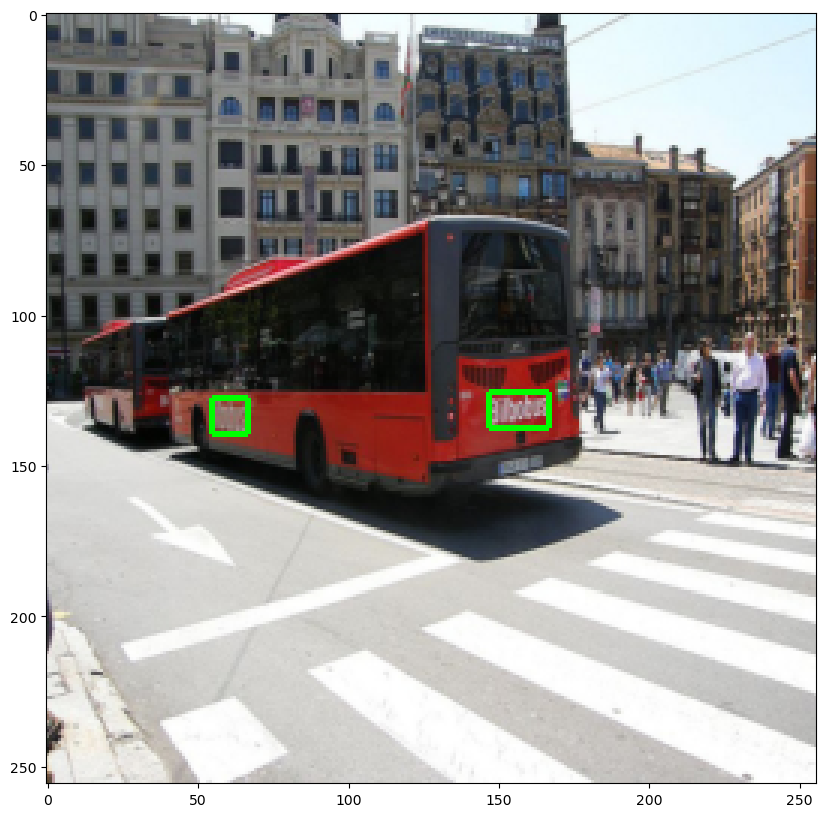

In [12]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [13]:
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss
import os

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [15]:
net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=1), hw=160)

In [16]:
net = train(ds_text, net=net, criterion=crit, batch_size=128, epochs=55, device=torch.device('cuda:0'), lr=1e-3)

/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = torch.tensor(objects[:, :, 2]).to(objects.device)
/home/ichuviliaeva/cv_hw3/course_cvdl/task2/abbyy_course_cvdl_t2/convert.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(objects[:, :, 3]).to(objects.device)


epoch 0|0; total loss:3438.553466796875
last losses: [51577.60546875, 0.22944912314414978, 0.466301828622818]
epoch 0|15; total loss:2998.482177734375
last losses: [649.49951171875, 0.24533647298812866, 0.27707910537719727]
epoch 0|30; total loss:646.7340698242188
last losses: [620.2913208007812, 0.23915410041809082, 0.25581902265548706]
epoch 0|45; total loss:497.7500915527344
last losses: [469.1839904785156, 0.2614639699459076, 0.36573949456214905]
epoch 0|60; total loss:406.8015441894531
last losses: [430.82281494140625, 0.21946868300437927, 0.23239749670028687]
epoch 0|75; total loss:384.81011962890625
last losses: [341.44903564453125, 0.2594549059867859, 0.25857505202293396]
epoch 0|90; total loss:377.3314208984375
last losses: [423.6588134765625, 0.2306983917951584, 0.2427031397819519]
epoch 0|105; total loss:348.91522216796875
last losses: [342.867919921875, 0.22453682124614716, 0.23378244042396545]
epoch 0|120; total loss:346.7080383300781
last losses: [325.5548095703125, 0.257

epoch 7|15; total loss:139.323486328125
last losses: [116.12031555175781, 0.20321282744407654, 0.2263334095478058]
epoch 7|30; total loss:138.191650390625
last losses: [132.55104064941406, 0.24066044390201569, 0.2583766579627991]
epoch 7|45; total loss:132.5122833251953
last losses: [111.95147705078125, 0.22970345616340637, 0.27571505308151245]
epoch 7|60; total loss:136.38534545898438
last losses: [117.03697967529297, 0.21601343154907227, 0.2095678746700287]
epoch 7|75; total loss:133.6044921875
last losses: [144.38499450683594, 0.2285953164100647, 0.27082887291908264]
epoch 7|90; total loss:144.92849731445312
last losses: [154.15518188476562, 0.23164187371730804, 0.23437991738319397]
epoch 7|105; total loss:145.9656524658203
last losses: [142.29830932617188, 0.23102004826068878, 0.2335333675146103]
epoch 7|120; total loss:156.1656951904297
last losses: [151.1800537109375, 0.24447771906852722, 0.27896344661712646]
epoch 7|135; total loss:152.0916748046875
last losses: [152.53207397460

epoch 14|30; total loss:50.5926399230957
last losses: [43.60240173339844, 0.2070896178483963, 0.2302607297897339]
epoch 14|45; total loss:48.9673957824707
last losses: [40.21969985961914, 0.21264058351516724, 0.24321219325065613]
epoch 14|60; total loss:45.93736267089844
last losses: [43.50563430786133, 0.2877083420753479, 0.265362411737442]
epoch 14|75; total loss:50.343841552734375
last losses: [46.903419494628906, 0.22220835089683533, 0.20745152235031128]
epoch 14|90; total loss:52.706886291503906
last losses: [65.34275817871094, 0.24056881666183472, 0.20698335766792297]
epoch 14|105; total loss:49.948158264160156
last losses: [46.85743713378906, 0.2629711627960205, 0.2887273132801056]
epoch 14|120; total loss:53.489131927490234
last losses: [56.5299072265625, 0.25185626745224, 0.1939103603363037]
epoch 14|135; total loss:49.31544876098633
last losses: [48.889949798583984, 0.26225244998931885, 0.2467205971479416]
epoch 15|0; total loss:2.8658831119537354
last losses: [42.47510147094

epoch 21|30; total loss:24.01342010498047
last losses: [21.560577392578125, 0.24611712992191315, 0.23313362896442413]
epoch 21|45; total loss:22.472368240356445
last losses: [21.393644332885742, 0.25279560685157776, 0.22972530126571655]
epoch 21|60; total loss:23.059162139892578
last losses: [23.151931762695312, 0.2615013122558594, 0.24258962273597717]
epoch 21|75; total loss:26.269445419311523
last losses: [28.462684631347656, 0.2556661367416382, 0.2410467565059662]
epoch 21|90; total loss:25.418603897094727
last losses: [22.78217315673828, 0.2327205389738083, 0.27007728815078735]
epoch 21|105; total loss:25.50577163696289
last losses: [21.060686111450195, 0.2400447428226471, 0.21261322498321533]
epoch 21|120; total loss:26.927915573120117
last losses: [27.483272552490234, 0.23658157885074615, 0.2102736383676529]
epoch 21|135; total loss:25.523767471313477
last losses: [32.32103729248047, 0.21987462043762207, 0.262784481048584]
epoch 22|0; total loss:1.6033252477645874
last losses: [2

epoch 28|30; total loss:16.163440704345703
last losses: [16.29417610168457, 0.25086280703544617, 0.19182148575782776]
epoch 28|45; total loss:14.751015663146973
last losses: [11.957423210144043, 0.24324938654899597, 0.23439744114875793]
epoch 28|60; total loss:14.627443313598633
last losses: [12.615429878234863, 0.19660106301307678, 0.2604673206806183]
epoch 28|75; total loss:16.33301544189453
last losses: [16.10390853881836, 0.24306060373783112, 0.25660401582717896]
epoch 28|90; total loss:15.974775314331055
last losses: [17.196365356445312, 0.22963225841522217, 0.2199546992778778]
epoch 28|105; total loss:16.979230880737305
last losses: [15.851029396057129, 0.2394823431968689, 0.2547219395637512]
epoch 28|120; total loss:18.34286880493164
last losses: [18.640962600708008, 0.23887282609939575, 0.21837358176708221]
epoch 28|135; total loss:18.614280700683594
last losses: [18.490930557250977, 0.21727833151817322, 0.2041768729686737]
epoch 29|0; total loss:0.6748608350753784
last losses:

epoch 35|30; total loss:12.632983207702637
last losses: [15.26851749420166, 0.2395527958869934, 0.23790571093559265]
epoch 35|45; total loss:11.891840934753418
last losses: [10.83799934387207, 0.23794004321098328, 0.23846736550331116]
epoch 35|60; total loss:12.527800559997559
last losses: [12.08104133605957, 0.24836495518684387, 0.29372721910476685]
epoch 35|75; total loss:12.48905086517334
last losses: [9.68577766418457, 0.2361326962709427, 0.2371709942817688]
epoch 35|90; total loss:13.181435585021973
last losses: [8.594597816467285, 0.25024276971817017, 0.22481408715248108]
epoch 35|105; total loss:15.09919261932373
last losses: [15.102065086364746, 0.22718162834644318, 0.2352566123008728]
epoch 35|120; total loss:12.346789360046387
last losses: [12.533561706542969, 0.26607757806777954, 0.2759188711643219]
epoch 35|135; total loss:14.900471687316895
last losses: [14.507905960083008, 0.2425796091556549, 0.2553737759590149]
epoch 36|0; total loss:0.6260240077972412
last losses: [8.85

epoch 42|30; total loss:7.986049175262451
last losses: [7.756209373474121, 0.2546956539154053, 0.24265894293785095]
epoch 42|45; total loss:9.954389572143555
last losses: [12.684488296508789, 0.2661128342151642, 0.23992925882339478]
epoch 42|60; total loss:9.305843353271484
last losses: [9.571781158447266, 0.252234548330307, 0.2617238163948059]
epoch 42|75; total loss:10.066214561462402
last losses: [8.68020248413086, 0.2466859519481659, 0.2745829224586487]
epoch 42|90; total loss:9.688194274902344
last losses: [7.1634979248046875, 0.22615143656730652, 0.21972233057022095]
epoch 42|105; total loss:10.230351448059082
last losses: [10.887775421142578, 0.27627241611480713, 0.23470133543014526]
epoch 42|120; total loss:10.872169494628906
last losses: [11.293596267700195, 0.23232437670230865, 0.21044984459877014]
epoch 42|135; total loss:12.078829765319824
last losses: [12.43327522277832, 0.23137354850769043, 0.21644093096256256]
epoch 43|0; total loss:0.5075175166130066
last losses: [7.087

epoch 49|45; total loss:7.026735782623291
last losses: [4.286388397216797, 0.24769747257232666, 0.21187707781791687]
epoch 49|60; total loss:7.235812187194824
last losses: [4.406937599182129, 0.24319742619991302, 0.2708651125431061]
epoch 49|75; total loss:7.957560062408447
last losses: [7.843374729156494, 0.25827062129974365, 0.22760236263275146]
epoch 49|90; total loss:8.183513641357422
last losses: [6.800173759460449, 0.2467578947544098, 0.2329465001821518]
epoch 49|105; total loss:7.661333084106445
last losses: [9.990747451782227, 0.22515106201171875, 0.24230003356933594]
epoch 49|120; total loss:8.559823036193848
last losses: [9.9330415725708, 0.22221457958221436, 0.21998313069343567]
epoch 49|135; total loss:8.629942893981934
last losses: [8.127754211425781, 0.2102201133966446, 0.19158926606178284]
epoch 50|0; total loss:0.5617227554321289
last losses: [7.919402122497559, 0.2545166611671448, 0.2519223093986511]
epoch 50|15; total loss:6.294001579284668
last losses: [7.73436546325

In [17]:
torch.save(net, 'centernet_coco2.pth')

In [18]:
with torch.no_grad():
    yp_heat = net(x[None].to('cuda:0')).cpu()    
    yp = net(x[None].to('cuda:0'), return_objects=True).cpu()

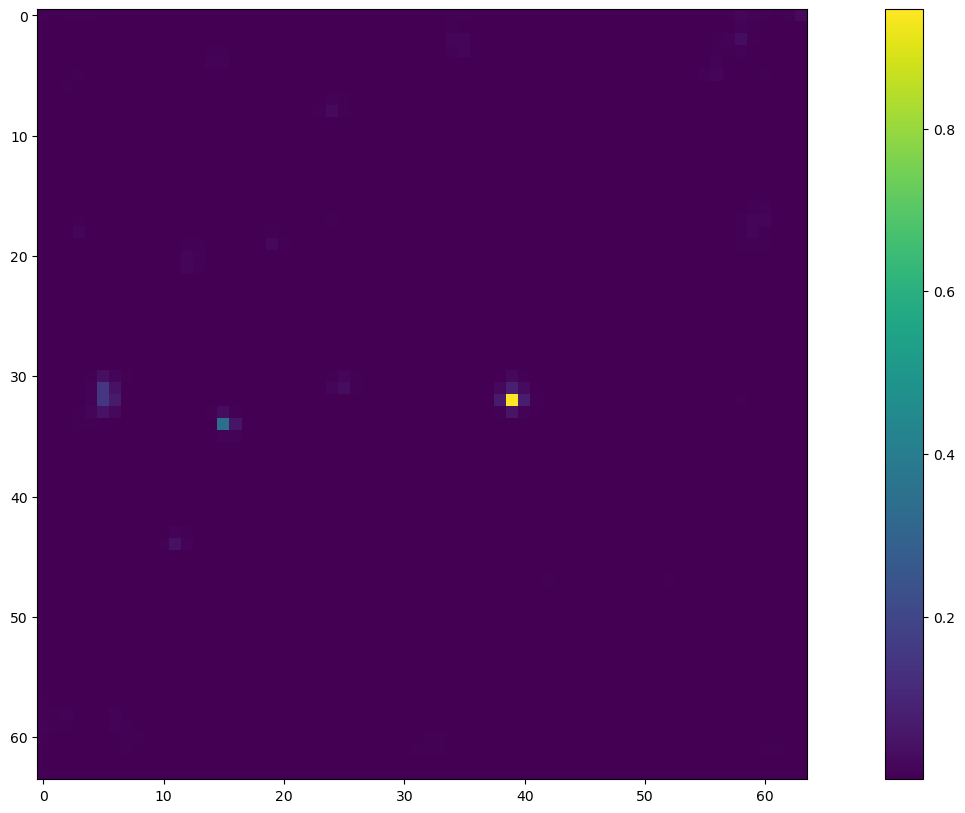

In [19]:
plt.imshow(yp_heat[0, 0])
plt.colorbar()

In [20]:
yp[0][:20]

tensor([[1.2992e+02, 1.5791e+02, 1.4517e+01, 1.9130e+01, 0.0000e+00, 9.4661e-01],
        [1.3804e+02, 6.2103e+01, 1.0695e+01, 1.6255e+01, 0.0000e+00, 3.4256e-01],
        [1.2996e+02, 2.2286e+01, 1.0576e+01, 2.1276e+01, 0.0000e+00, 1.5118e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e

In [21]:
y[:6]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


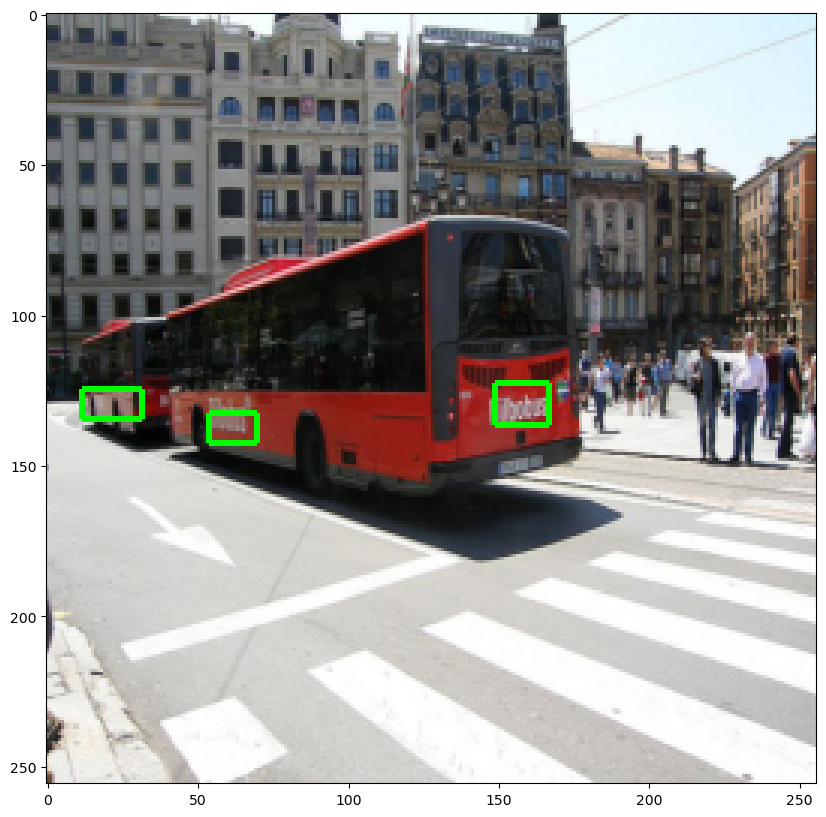

In [22]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
));